## Imports

In [2]:
import pandas as pd
import numpy as np

df_AA2024 = pd.read_excel('/workspaces/project-project-surface-science-syndicate/data/averaged_filtered_AA2024.xlsx')
print(df_AA2024.describe())

           Time_h          pH  Inhib_Concentrat_M  Salt_Concentrat_M  \
count  515.000000  515.000000          515.000000         515.000000   
mean   157.151456    6.613592            0.006934           0.113476   
std    212.312862    2.270734            0.012923           0.159137   
min      0.500000    0.000000            0.000010           0.000000   
25%     24.000000    4.400000            0.001000           0.050000   
50%     24.000000    7.000000            0.001000           0.100000   
75%    240.000000    7.000000            0.003000           0.100000   
max    672.000000   10.000000            0.100000           0.600000   

        Efficiency  
count   515.000000  
mean     18.439395  
std     313.671188  
min   -4834.000000  
25%      25.625000  
50%      50.000000  
75%      85.475000  
max     100.000000  


In [3]:
print(df_AA2024.head())

                                  SMILES  Time_h    pH  Inhib_Concentrat_M  \
0                   C(=O)(C(=O)[O-])[O-]    24.0   4.0              0.0010   
1                   C(=O)(C(=O)[O-])[O-]    24.0   7.0              0.0005   
2                   C(=O)(C(=O)[O-])[O-]    24.0  10.0              0.0010   
3  C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O    24.0   4.0              0.0010   
4  C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O    24.0   7.0              0.0005   

   Salt_Concentrat_M  Efficiency  
0               0.10       20.00  
1               0.05       12.35  
2               0.10       20.00  
3               0.10       30.00  
4               0.05      -23.95  


In [4]:
df_AA1000 = pd.read_excel('/workspaces/project-project-surface-science-syndicate/data/averaged_filtered_AA1000.xlsx')
print(df_AA1000.describe())

           Time_h          pH  Inhib_Concentrat_M  Salt_Concentrat_M  \
count  333.000000  333.000000        3.330000e+02         333.000000   
mean    79.969970    0.440733        1.510580e-01           0.051051   
std    143.826377    1.913196        5.784776e-01           0.301263   
min      0.000000   -0.600000        1.000000e-07           0.000000   
25%      2.000000   -0.136721        2.000000e-04           0.000000   
50%      5.500000    0.000000        1.800000e-03           0.000000   
75%     96.000000    1.000000        4.279601e-03           0.000000   
max    720.000000   13.000000        3.280000e+00           2.000000   

       Efficiency  
count  333.000000  
mean    60.781498  
std     22.139768  
min    -49.170000  
25%     47.066667  
50%     66.000000  
75%     77.220000  
max     96.200000  


Construct dataframe to work with

In [5]:
df = df_AA2024
df_transfer = df_AA1000

In [6]:
df_combined = pd.concat([df, df_transfer], axis=0)

In [7]:
df_combined.describe()

,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency
count,848.000000,848.000000,8.480000e+02,848.000000,848.000000
mean,126.843160,4.189580,6.352976e-02,0.088962,35.066659
std,192.055676,3.696183,3.690920e-01,0.227758,245.617010
min,0.000000,-0.600000,1.000000e-07,0.000000,-4834.000000
25%,6.000000,0.000000,5.000000e-04,0.000000,35.000000
50%,24.000000,4.000000,1.000000e-03,0.010000,60.000000
75%,144.000000,7.000000,4.200000e-03,0.100000,80.507500
max,720.000000,13.000000,3.280000e+00,2.000000,100.000000


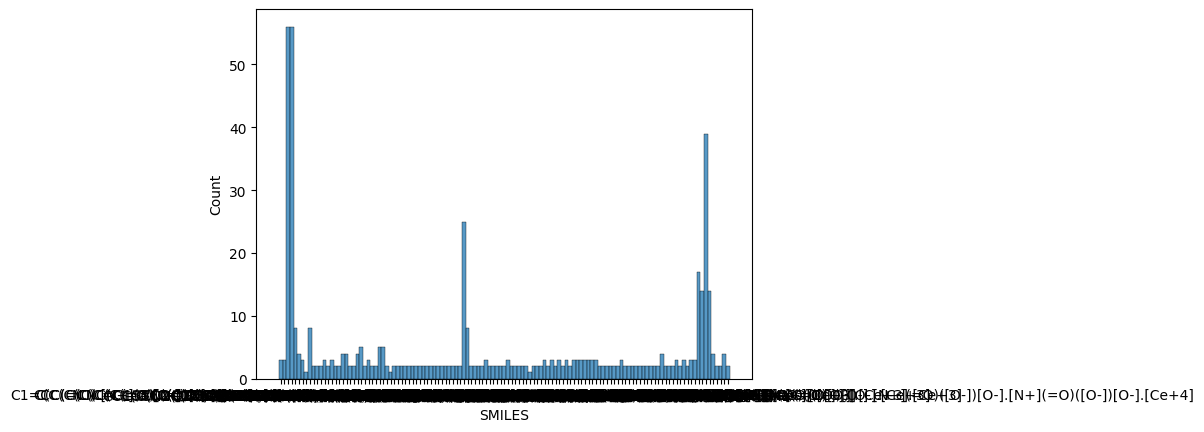

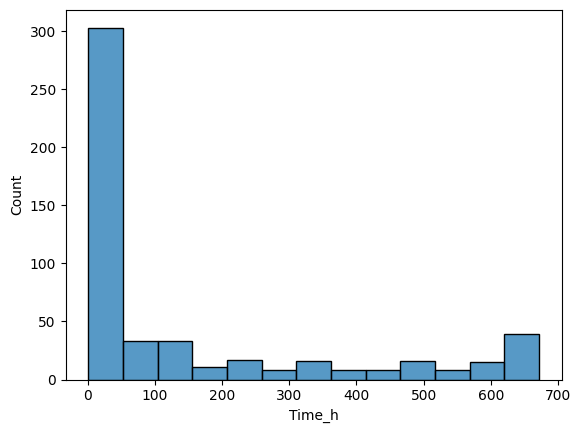

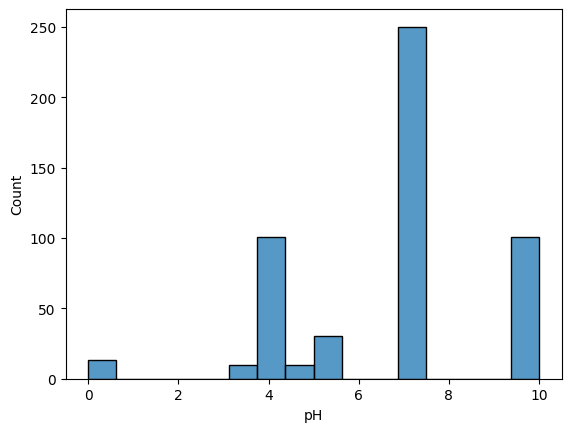

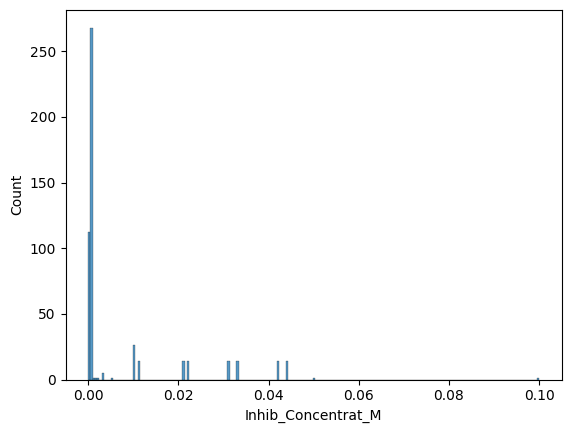

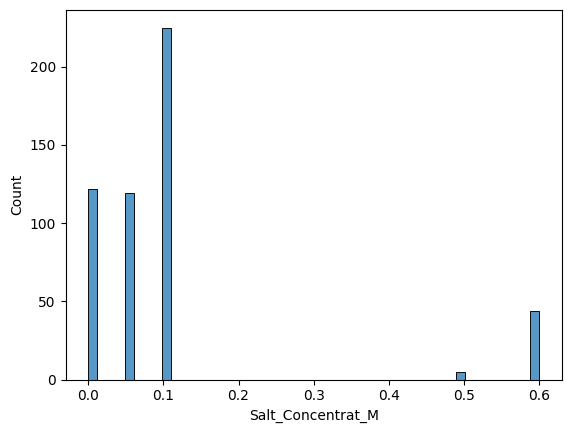

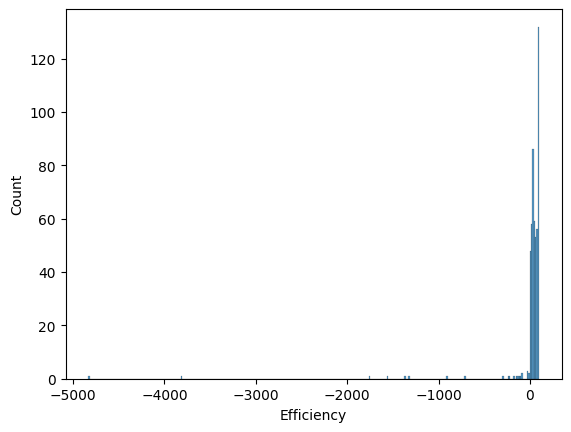

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

for i, column in enumerate(df.columns, 1):
    sns.histplot(df[column])
    plt.show()

### Set targets/objectives = efficiency for now

In [9]:
from baybe.targets import NumericalTarget
from baybe.objective import Objective

target = NumericalTarget(
    name="Efficiency",
    mode="MAX",
)
objective = Objective(mode="SINGLE", targets=[target])

/home/vscode/.local/lib/python3.10/site-packages/baybe/telemetry.py:222: UserWarning: WARNING: BayBE Telemetry endpoint https://public.telemetry.baybe.p.uptimize.merckgroup.com:4317 cannot be reached. Disabling telemetry. The exception encountered was: ConnectionError, HTTPConnectionPool(host='verkehrsnachrichten.merck.de', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7f86955630a0>: Failed to resolve 'verkehrsnachrichten.merck.de' ([Errno -2] Name or service not known)"))
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Search Space

In [10]:
from baybe.parameters import NumericalContinuousParameter, CategoricalParameter, NumericalDiscreteParameter
from baybe.searchspace import SearchSpace

basic_parameters=[
NumericalDiscreteParameter(
    name="Time_h",
    values=df_combined["Time_h"].unique(),
    tolerance=5/60,
),
NumericalDiscreteParameter(
    name="pH",
    values=df_combined["pH"].unique(),
    ),  
NumericalDiscreteParameter(
    name="Inhib_Concentrat_M",
    values=df_combined["Inhib_Concentrat_M"].unique(),
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_combined["Salt_Concentrat_M"].unique(),
    ),
]

**Substance parameter**

Instead of values, this parameter accepts data in form of a dictionary. The items correspond to pairs of labels and SMILES. SMILES are string-based representations of molecular structures. Based on these, BayBE can assign each label a set of molecular descriptors as encoding.

In [11]:
#Create a dictionary of unique SMILES representations found in the dataframe

unique_SMILES = df_combined["SMILES"].unique()

dic_SMILES = dict(zip(unique_SMILES, unique_SMILES))

print(dic_SMILES)

{'C(=O)(C(=O)[O-])[O-]': 'C(=O)(C(=O)[O-])[O-]', 'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O': 'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O', 'C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O-])O)O)O)O)O.[Fe+2]': 'C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O-])O)O)O)O)O.[Fe+2]', 'C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O-])O)O)O)O)O.[Zn+2]': 'C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O-])O)O)O)O)O.[Zn+2]', 'C1=CC(=C(C=C1O)O)C=NNC(=S)N': 'C1=CC(=C(C=C1O)O)C=NNC(=S)N', 'C1=CC(=C(C=C1SSC2=CC(=C(C=C2)[N+](=O)[O-])C(=O)O)C(=O)O)[N+](=O)[O-]': 'C1=CC(=C(C=C1SSC2=CC(=C(C=C2)[N+](=O)[O-])C(=O)O)C(=O)O)[N+](=O)[O-]', 'C1=CC(=CC(=C1)S)C(=O)O': 'C1=CC(=CC(=C1)S)C(=O)O', 'C1=CC2=NNN=C2C=C1Cl': 'C1=CC2=NNN=C2C=C1Cl', 'C1=CC=C(C(=C1)C=NNC(=S)N)O': 'C1=CC=C(C(=C1)C=NNC(=S)N)O', 'C1COCCN1CCCS(=O)(=O)O': 'C1COCCN1CCCS(=O)(=O)O', 'C1N2CN3CN1CN(C2)C3': 'C1N2CN3CN1CN(C2)C3', 'C=CC(=O)OCCOC(=O)OCCSc1ncccn1': 'C=CC(=O)OCCOC(=O)OCCSc1ncccn1', 'CC(=O)O': 'CC(=O)O', 'CC(=O)SSC(=O)C': 'CC(=O)SSC(=O)C', 'CC1(C(

In [12]:
from baybe.parameters import SubstanceParameter

mordred_parameters = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=dic_SMILES,
        encoding="MORDRED",
    )
]

rdkit_parameters = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=dic_SMILES,
        encoding="RDKIT",
    )
]

morganfp_parameters = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=dic_SMILES,
        encoding="MORGAN_FP",
    )
]

ohe_parameters = basic_parameters + [
    CategoricalParameter(
        name="SMILES",
        values=unique_SMILES,
        encoding="OHE",
    )
]

In [13]:
searchspace_mordred = SearchSpace.from_dataframe(df.drop("Efficiency", axis = 1), mordred_parameters)
searchspace_rdkit = SearchSpace.from_dataframe(df.drop("Efficiency", axis = 1), rdkit_parameters)
searchspace_morganfp = SearchSpace.from_dataframe(df.drop("Efficiency", axis = 1), morganfp_parameters)
searchspace_ohe = SearchSpace.from_dataframe(df.drop("Efficiency", axis = 1), ohe_parameters)

### Recommenders

The **SequentialGreedyRecommender** is a powerful recommender that leverages BoTorch optimization functions to perform sequential Greedy optimization. It can be applied for discrete, continuous and hybrid sarch spaces. It is an implementation of the BoTorch optimization functions for discrete, continuous and mixed spaces. **It is important to note that this recommender performs a brute-force search when applied in hybrid search spaces, as it optimizes the continuous part of the space while exhaustively searching choices in the discrete subspace.** You can customize this behavior to only sample a certain percentage of the discrete subspace via the sample_percentage attribute and to choose different sampling strategies via the hybrid_sampler attribute. 

e.g.
strategy = TwoPhaseStrategy(recommender=SequentialGreedyRecommender(hybrid_sampler="Farthest", sampling_percentage=0.3))

For implementing fully customized surrogate models e.g. from sklearn or PyTorch, see:
https://emdgroup.github.io/baybe/examples/Custom_Surrogates/Custom_Surrogates.html


In [14]:
from baybe.recommenders import (
    SequentialGreedyRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
)

recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=SequentialGreedyRecommender(),  # Bayesian model-based optimization
)

### Campaign Strategy

In [15]:
from baybe.strategies import TwoPhaseStrategy
from baybe import Campaign

campaign_rdkit = Campaign(searchspace_rdkit, objective)
campaign_mordred = Campaign(searchspace_mordred, objective)
campaign_morganfp = Campaign(searchspace_morganfp, objective)
campaign_ohe = Campaign(searchspace_ohe, objective)

### Start simulation

In [16]:
scenarios = {
    "OHE" : campaign_ohe,
}

In [17]:
from baybe.simulation import simulate_scenarios

N_MC_ITERATIONS = 10
N_DOE_ITERATIONS = 50
BATCH_SIZE = 1

results = simulate_scenarios(
    scenarios,
    df,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    impute_mode="best",
)

  0%|          | 0/10 [00:00<?, ?it/s]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


 10%|#         | 1/10 [00:09<01:24,  9.35s/it]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
 20%|##        | 2/10 [00:17<01:10,  8.82s/it]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction fac

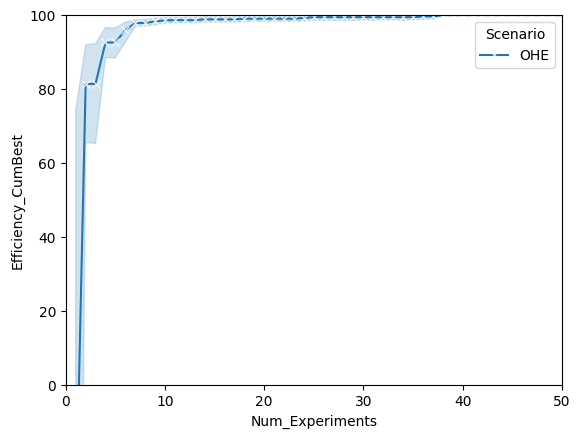

In [18]:
sns.lineplot(
    data=results,
    x="Num_Experiments",
    y="Efficiency_CumBest",
    hue="Scenario",
    marker="x",
)

plt.xlim(0, N_DOE_ITERATIONS)
plt.ylim(0, 100)

plt.savefig("Scenarios")

# Evalute best results

In [19]:
print(results.columns)

Index(['Scenario', 'Random_Seed', 'Iteration', 'Num_Experiments',
       'Efficiency_Measurements', 'Efficiency_IterBest', 'Efficiency_CumBest'],
      dtype='object')


## Use transfer learning on other metals

Define the training function (i.e. the previously investigated larger data set) and the yet to be optimized data sets.

In [20]:
from baybe.parameters import TaskParameter

taskparam = TaskParameter(
    name="Al_alloys",
    values=["AA1000", "AA2024"],
    active_values=["AA2024"],
)

In [21]:
unique_SMILES_transfer = df_transfer["SMILES"].unique()

In [59]:
from baybe.parameters import NumericalContinuousParameter, CategoricalParameter, NumericalDiscreteParameter
from baybe.searchspace import SearchSpace

transfer_parameters=[
NumericalDiscreteParameter(
    name="Time_h",
    values=df_combined["Time_h"].unique(),
    tolerance=5/60,
),
NumericalDiscreteParameter(
    name="pH",
    values=df_combined["pH"].unique(),
    ),  
NumericalDiscreteParameter(
    name="Inhib_Concentrat_M",
    values=df_combined["Inhib_Concentrat_M"].unique(),
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_combined["Salt_Concentrat_M"].unique(),
    ),
CategoricalParameter(
    name="SMILES",
    values=unique_SMILES,
    encoding="OHE",
    )
]

In [60]:
searchspace_transfer = SearchSpace.from_dataframe(df_transfer.drop("Efficiency", axis = 1), transfer_parameters)

campaign_transfer = Campaign(searchspace_transfer, objective)

In [61]:
df_features = df.drop("Efficiency", axis = 1)

In [62]:
results_transfer: list[pd.DataFrame] = []
fractions = (0.01, 0.2)


result_fresh_start = simulate_scenarios(
    {"Fresh": campaign_transfer},
    df_transfer,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    impute_mode="best",
)

  0%|          | 0/1 [00:00<?, ?it/s]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


100%|##########| 1/1 [00:06<00:00,  6.61s/it]


In [63]:
fraction_df = df.sample(frac=0.5)
training_lookup = [fraction_df for _ in range(N_MC_ITERATIONS)]

result_transfer_learning = simulate_scenarios(
    {"Transfer": campaign_transfer},
    df_transfer,
    initial_data=training_lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    impute_mode="best",
)

  0%|          | 0/10 [00:00<?, ?it/s]Input row with index 350 could not be matched to the search space. This could indicate that something went wrong.
Input row with index 304 could not be matched to the search space. This could indicate that something went wrong.
Input row with index 256 could not be matched to the search space. This could indicate that something went wrong.
Input row with index 167 could not be matched to the search space. This could indicate that something went wrong.
Input row with index 339 could not be matched to the search space. This could indicate that something went wrong.
Input row with index 317 could not be matched to the search space. This could indicate that something went wrong.
Input row with index 181 could not be matched to the search space. This could indicate that something went wrong.
Input row with index 345 could not be matched to the search space. This could indicate that something went wrong.
Input row with index 24 could not be matched to th

In [66]:
fraction_df.describe()

,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency
count,258.000000,258.000000,258.000000,258.000000,258.000000
mean,161.091085,6.579845,0.008103,0.127403,38.761628
std,214.536317,2.241608,0.014335,0.177444,158.903313
min,0.500000,0.000000,0.000010,0.000000,-1760.000000
25%,24.000000,5.400000,0.001000,0.050000,30.000000
50%,24.000000,7.000000,0.001000,0.100000,57.500000
75%,240.000000,7.000000,0.010000,0.100000,87.825000
max,672.000000,10.000000,0.100000,0.600000,100.000000


In [65]:
# Add an additional column to each dataframe
fractions = (0.01, 0.2)
for i, df in enumerate(results_transfer):
    df['Fraction'] = fractions[i]

# Concatenate the dataframes into a single dataframe
concatenated_df = pd.concat(results_transfer, ignore_index=True)

# Print the concatenated dataframe
print(concatenated_df)

ValueError: No objects to concatenate

In [ ]:
results = 

,Random_Seed,Iteration,Num_Experiments,Efficiency_IterBest,Efficiency_CumBest
count,50.0,50.00000,50.00000,50.000000,50.000000
mean,1337.0,24.50000,25.50000,68.424718,86.399133
std,0.0,14.57738,14.57738,23.775399,11.036087
min,1337.0,0.00000,1.00000,4.390000,57.000000
25%,1337.0,12.25000,13.25000,50.806000,78.380000
50%,1337.0,24.50000,25.50000,79.910000,90.000000
75%,1337.0,36.75000,37.75000,87.328214,93.590000
max,1337.0,49.00000,50.00000,96.200000,96.200000


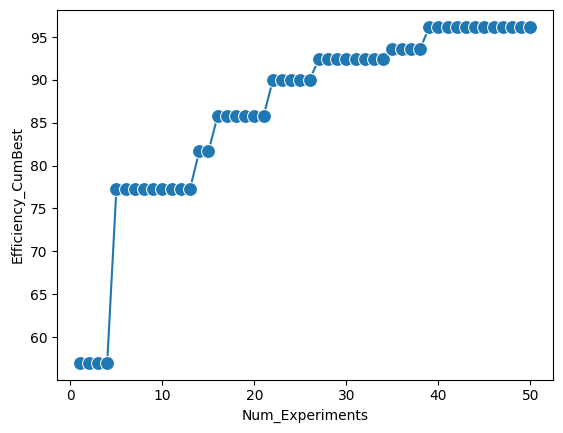

In [ ]:

ax = sns.lineplot(
    data=result_fraction,
    marker="o",
    markersize=10,
    x="Num_Experiments",
    y="Efficiency_CumBest",
)

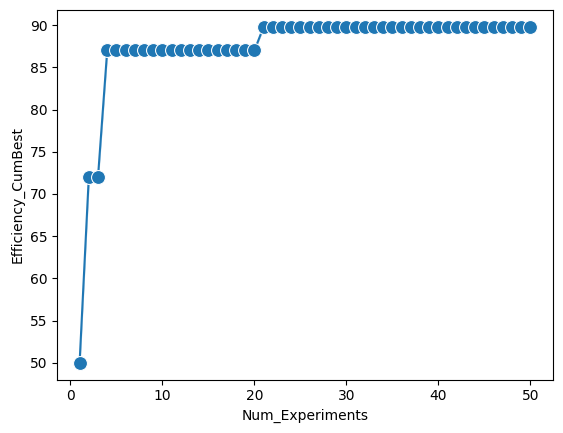

In [67]:
ax = sns.lineplot(
    data=result_transfer_learning,
    marker="o",
    markersize=10,
    x="Num_Experiments",
    y="Efficiency_CumBest",
)